In [ ]:
!pip install tensorflow-gpu==2.3.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)
!nvidia-smi -L

Found GPU at: /device:GPU:0
2.3.0
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-33b03852-2f3d-26e8-60ec-5ed9d6d00c58)


In [ ]:
import os     
import numpy as np
import pandas as pd
from tensorflow import keras
import pathlib
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [ ]:
%cd /content/
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar xvf flower_photos.tgz

/content
--2020-09-08 00:10:18--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz.1’

flower_photos.tgz.1 100%[===================>] 218.21M  71.6MB/s    in 3.0s    

2020-09-08 00:10:21 (71.6 MB/s) - ‘flower_photos.tgz.1’ saved [228813984/228813984]

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a2

In [ ]:
flowers_dir  = '/content/flower_photos'
NUM_CLASSES   = 5
classes = ['0','1','2','3','4']

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 3123 images belonging to 5 classes.
Found 547 images belonging to 5 classes.


In [ ]:
# Creates label file
!mkdir /content/model
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('/content/model/flower_labels.txt', 'w') as f:
  f.write(labels)
with open('/content/model/flower_labels.txt', 'r') as f:
  labels = [line.strip() for line in f.readlines()]
print(labels)

mkdir: cannot create directory ‘/content/model’: File exists
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
%cd /content
!git clone https://github.com/qubvel/efficientnet.git
%cd /content/efficientnet
!pip install -r requirements.txt

/content
fatal: destination path 'efficientnet' already exists and is not an empty directory.
/content/efficientnet


In [ ]:
import efficientnet.tfkeras as efn 
model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation='softmax')(x)
model = Model(inputs = model.inputs, outputs=output_layer)
model.trainable = True 
model.summary()

31940608/31936256 [==============================] - 1s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________

In [ ]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if (logs.get('accuracy') > 0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

callback_func = callback()

model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[callback_func])

Epoch 1/100
 2/49 [>.............................] - ETA: 9s - loss: 1.8476 - accuracy: 0.1250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1093s vs `on_train_batch_end` time: 0.2952s). Check your callbacks.


49/49 [==============================] - 23s 478ms/step - loss: 1.6922 - accuracy: 0.2424 - val_loss: 1.5669 - val_accuracy: 0.2870
Epoch 2/100
49/49 [==============================] - 21s 434ms/step - loss: 1.4748 - accuracy: 0.3673 - val_loss: 1.3722 - val_accuracy: 0.4698
Epoch 3/100
49/49 [==============================] - 21s 433ms/step - loss: 1.2890 - accuracy: 0.5069 - val_loss: 1.2116 - val_accuracy: 0.5777
Epoch 4/100
49/49 [==============================] - 21s 434ms/step - loss: 1.1411 - accuracy: 0.5860 - val_loss: 1.0682 - val_accuracy: 0.6673
Epoch 5/100
49/49 [==============================] - 21s 433ms/step - loss: 1.0031 - accuracy: 0.6750 - val_loss: 0.9346 - val_accuracy: 0.7276
Epoch 6/100
49/49 [==============================] - 21s 431ms/step - loss: 0.8833 - accuracy: 0.7275 - val_loss: 0.8118 - val_accuracy: 0.7879
Epoch 7/100
49/49 [==============================] - 21s 429ms/step - loss: 0.7786 - accuracy: 0.7704 - val_loss: 0.7124 - val_accuracy: 0.8135
Epoc

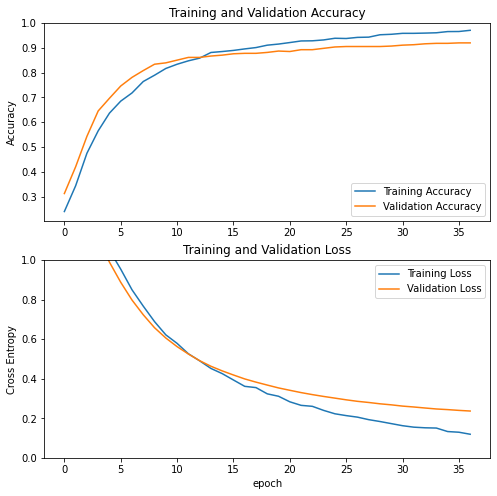

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluates raw model
batch_images, batch_labels = next(val_generator)
logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)
keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)
print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 90.625%


In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(flowers_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

# This is necessary to set batch as static
model.input.set_shape((1,) + model.input.shape[1:])
print(model.input.shape)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/model/efficientnet_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

(1, 224, 224, 3)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp53bfqd4z/assets


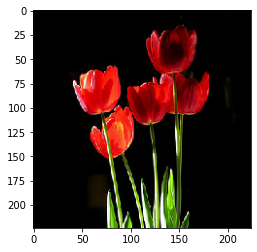

tulips 0.99609375 



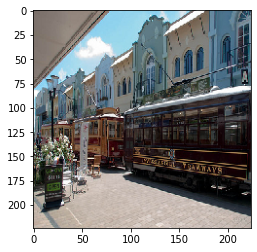

tulips 0.58984375 



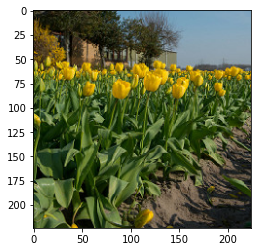

tulips 0.91015625 



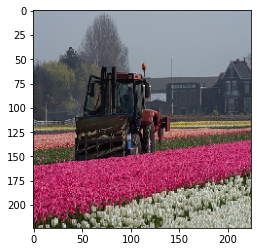

tulips 0.77734375 



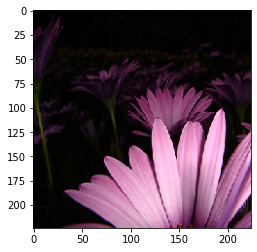

daisy 0.92578125 



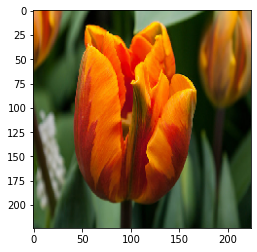

tulips 0.9921875 



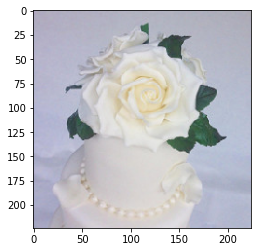

roses 0.9921875 



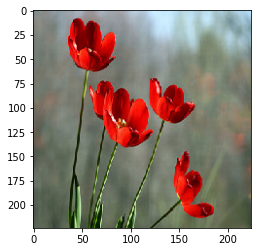

tulips 0.99609375 



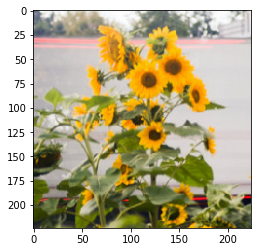

sunflowers 0.99609375 



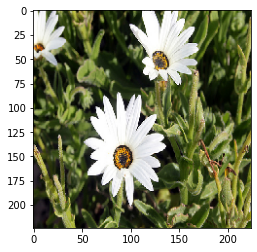

daisy 0.99609375 



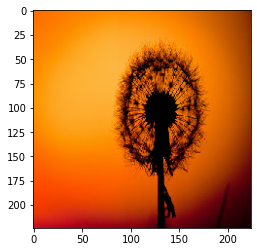

dandelion 0.8828125 



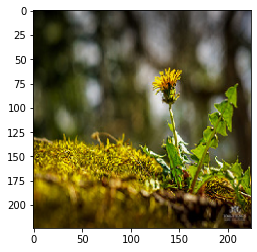

dandelion 0.9609375 



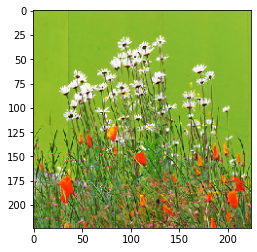

tulips 0.83984375 



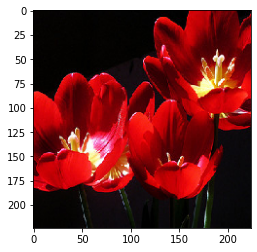

tulips 0.99609375 



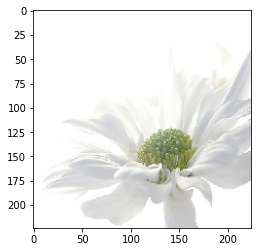

daisy 0.83984375 



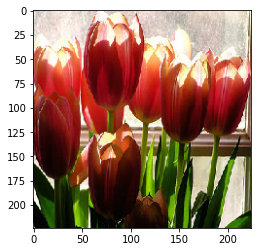

tulips 0.99609375 



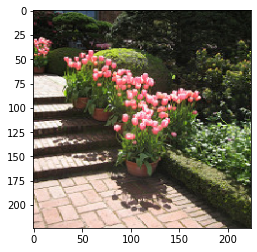

roses 0.59375 



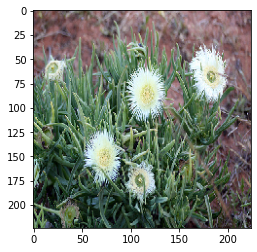

dandelion 0.83203125 



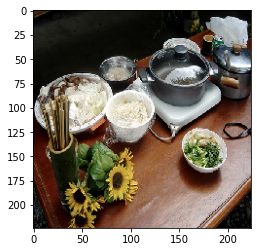

roses 0.72265625 



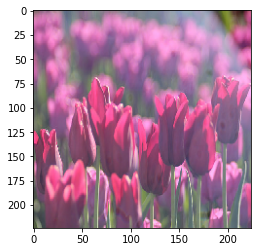

tulips 0.99609375 



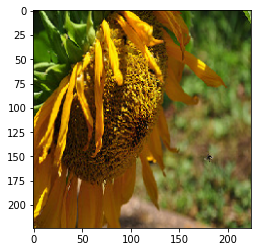

sunflowers 0.9921875 



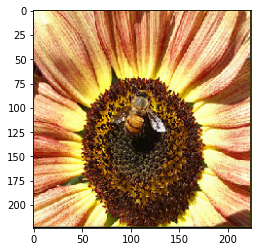

sunflowers 0.98046875 



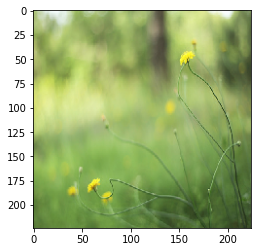

dandelion 0.84765625 



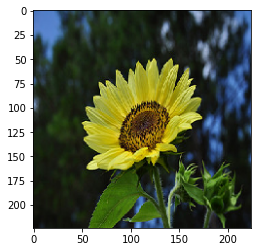

sunflowers 0.984375 



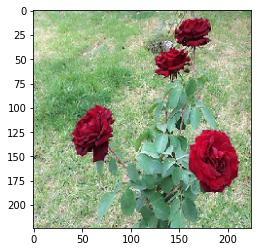

roses 0.99609375 



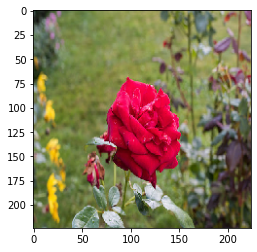

roses 0.99609375 



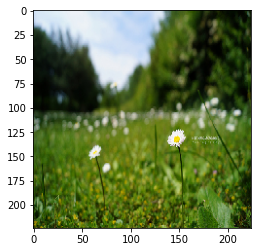

daisy 0.796875 



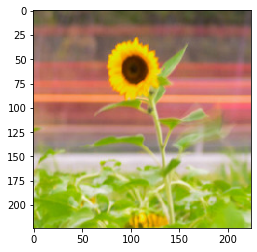

sunflowers 0.95703125 



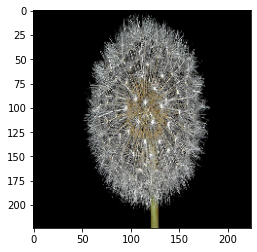

dandelion 0.98046875 



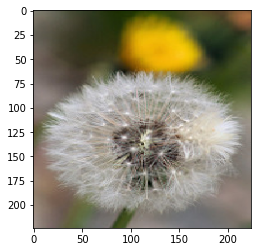

dandelion 0.99609375 



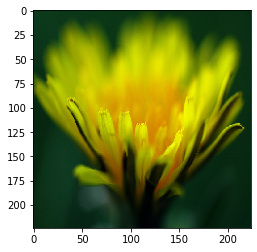

dandelion 0.625 



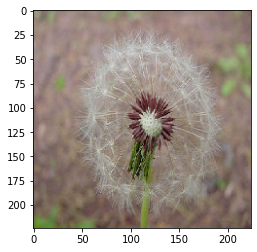

dandelion 0.99609375 



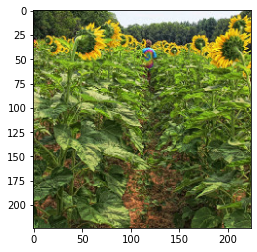

sunflowers 0.984375 



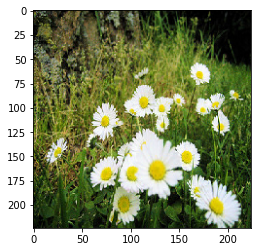

daisy 0.99609375 



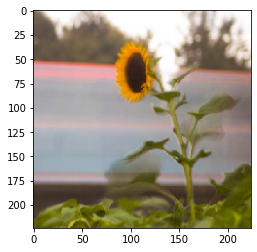

sunflowers 0.98046875 



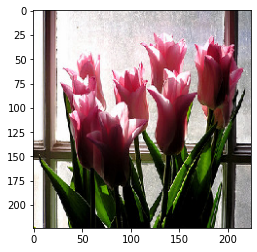

tulips 0.99609375 



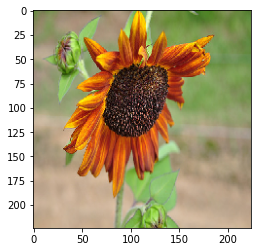

sunflowers 0.98828125 



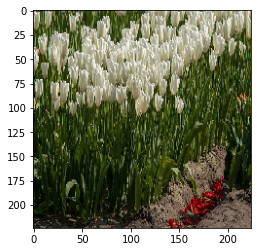

tulips 0.89453125 



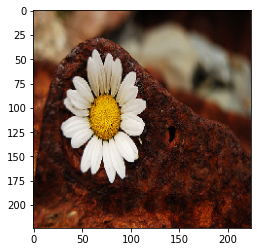

daisy 0.99609375 



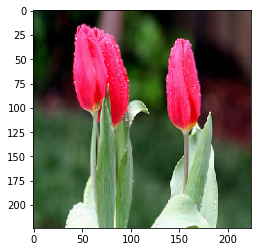

tulips 0.98046875 



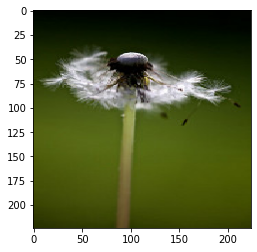

dandelion 0.9921875 



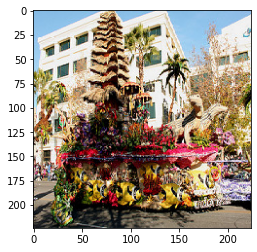

roses 0.85546875 



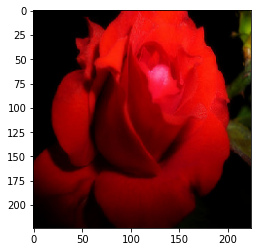

roses 0.9765625 



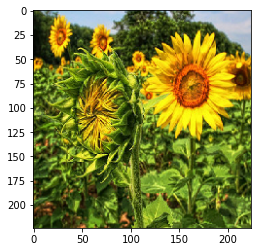

sunflowers 0.99609375 



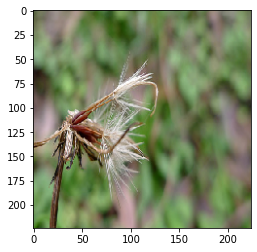

dandelion 0.99609375 



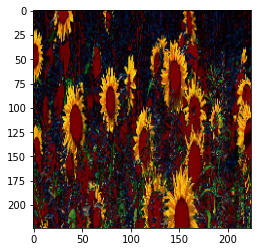

sunflowers 0.80859375 



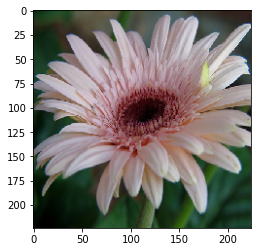

dandelion 0.48046875 



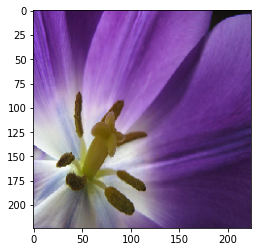

daisy 0.44140625 



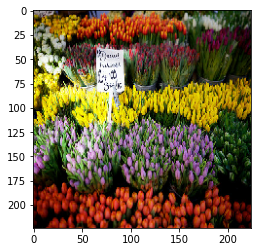

tulips 0.60546875 



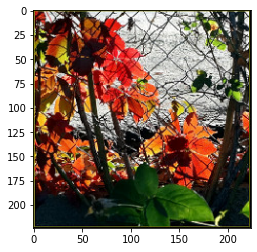

roses 0.796875 



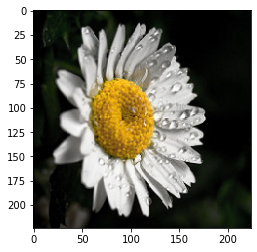

daisy 0.9921875 



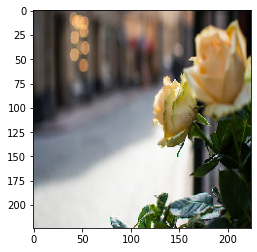

roses 0.87109375 



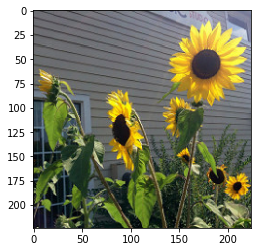

sunflowers 0.99609375 



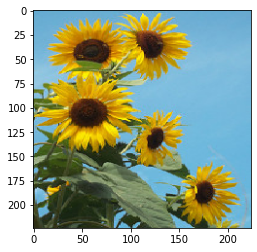

sunflowers 0.99609375 



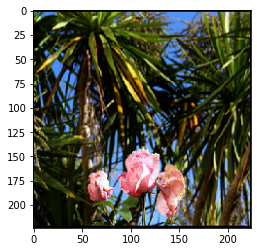

roses 0.85546875 



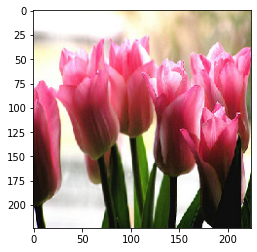

tulips 0.99609375 



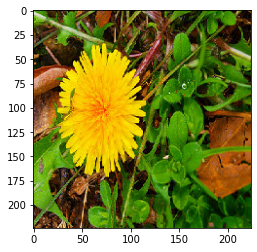

dandelion 0.984375 



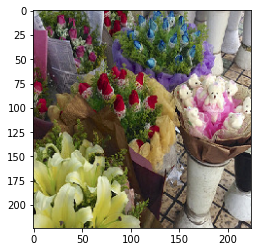

roses 0.83984375 



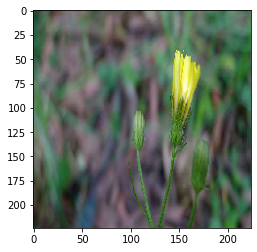

dandelion 0.3984375 



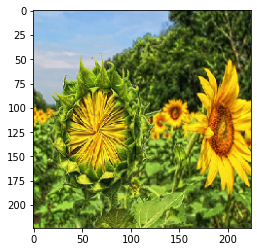

sunflowers 0.99609375 



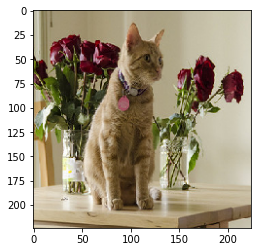

roses 0.79296875 



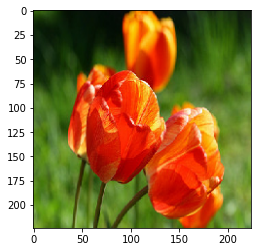

tulips 0.91796875 



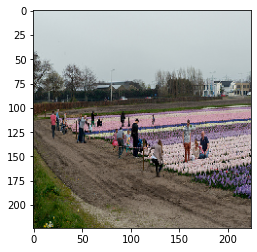

tulips 0.98046875 



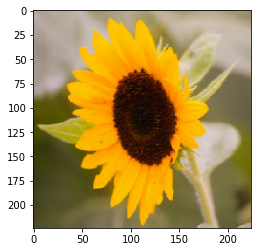

sunflowers 0.98828125 

-------------------
Quant TF Lite accuracy: 87.500%


In [ ]:
%matplotlib inline

# Check tflite model
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  return np.argmax(output), max(output[0])

interpreter = tf.lite.Interpreter('/content/model/efficientnet_224_quant.tflite')
interpreter.allocate_tensors()

batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)
for i in range(len(batch_images)):
  plt.imshow(batch_images[i])
  plt.show()
  prediction, score = classify_image(interpreter, batch_images[i])
  print(labels[prediction], score, '\n')
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print('-------------------')
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


In [ ]:
# Install edgetpu compiler
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  15186      0 --:--:-- --:--:-- --:--:-- 15547
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran3

In [ ]:
# Compile the model
%cd /content/model
!edgetpu_compiler -s efficientnet_224_quant.tflite

/content/model
Edge TPU Compiler version 14.1.317412892

Model compiled successfully in 5527 ms.

Input model: efficientnet_224_quant.tflite
Input size: 7.83MiB
Output model: efficientnet_224_quant_edgetpu.tflite
Output size: 8.55MiB
On-chip memory used for caching model parameters: 4.62MiB
On-chip memory remaining for caching model parameters: 1.25KiB
Off-chip memory used for streaming uncached model parameters: 3.16MiB
Number of Edge TPU subgraphs: 1
Total number of operations: 366
Operation log: efficientnet_224_quant_edgetpu.log

Operator                       Count      Status

FULLY_CONNECTED                1          Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
MUL                            92         Mapped to Edge TPU
CONV_2D                        92         Mapped to Edge TPU
DEPTHWISE_CONV_2D              23         Mapped to Edge TPU
RESHAPE                        23         Mapped to Edge TPU
MEAN                           24         Ma

In [ ]:
# Package everything and then download it
%cd /content
!tar cvf model.tar.gz model
from google.colab import files
files.download('model.tar.gz')

/content
model/
model/flower_labels.txt
model/efficientnet_224_quant_edgetpu.tflite
model/efficientnet_224_quant_edgetpu.log
model/efficientnet_224_quant.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>